# Bayesian GNN for regression on Molecules

Here we will compare the perform regression of molecules using Bayesian GNNs, inspired by Hwang et al. 2020 (https://pubs.acs.org/doi/abs/10.1021/acs.jcim.0c00416). The feature extractor used here is the GIN architecture, with the same graph features used in the graph kernel experiments. Here we rely on a final Bayesian linear layers from Bayesian-Torch (https://github.com/IntelLabs/bayesian-torch).

The densely connected final layer will have weight *distributions* rather than deterministic weights. The uncertainty of the model will be obtained by repeatedly sampling the network for predictions. We recommend using the CUDA to increase the speed of training the GNN.

## Set up datasets and import packages

In [1]:
import os, sys
sys.path.append('..')
from tqdm import tqdm
import copy

import warnings
warnings.filterwarnings("ignore")

# import sklearn
from gauche.dataloader import DataLoaderMP
from gauche.dataloader.data_utils import transform_data
from gauche.kernels.gnn_kernels.pretrained_kernel import GNN, mol_to_pyg

import pandas as pd
import numpy as np
import rdkit.Chem.AllChem as Chem
import matplotlib.pyplot as plt

from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import global_mean_pool
from torch_geometric.loader import DataLoader
from bayesian_torch.layers import LinearFlipout, LinearReparameterization

To use the Graphein submodule graphein.protein.features.sequence.embeddings, you need to install: biovec 
biovec cannot be installed via conda
To do so, use the following command: conda install -c pytorch3d pytorch3d
To do so, use the following command: conda install -c pytorch3d pytorch3d


In [2]:
# set paths
dataset_paths = {
    "Photoswitch": "../data/property_prediction/photoswitches.csv",
    "ESOL": "../data/property_prediction/ESOL.csv",
    "FreeSolv": "../data/property_prediction/FreeSolv.csv",
    "Lipophilicity": "../data/property_prediction/Lipophilicity.csv",
}
    

## Create model


In [3]:
class BayesianGNN(nn.Module):
    def __init__(self, embed_dim=300, num_layers=5, gnn_type='gin', output_dim=1):
        super().__init__()
        self.gnn = GNN(num_layers=num_layers, embed_dim=embed_dim, gnn_type=gnn_type)
        self.pooling = global_mean_pool
        self.bayes_layer = LinearReparameterization(embed_dim, output_dim)
        
    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        res = self.gnn(x, edge_index, edge_attr)
        res = self.pooling(res, batch)

        # bayesian layer
        kl_sum = 0
        res, kl = self.bayes_layer(res)
        kl_sum += kl
        return res, kl_sum

In [4]:
def nlpd(y, y_pred, y_std):
    nld = 0
    for y_true, mu, std in zip(y.ravel(), y_pred.ravel(), y_std.ravel()):
        nld  += -norm(mu, std).logpdf(y_true)
    return nld / len(y)

def predict(regressor, X, samples = 100):
    preds = [regressor(X)[0] for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0)
    var = preds.var(axis=0)
    return means, var

def graph_append_label(X, y, device):
    G = []
    for g, label in zip(X, y):
        g.y = label
        g = g.to(device)
        G.append(g)
    return G

In [5]:
def evaluate_model(X, y, n_epochs=100, n_trials=20, kld_beta = 1., verbose=True):
    test_set_size = 0.2
    batch_size = 32
    
    r2_list = []
    rmse_list = []
    mae_list = []
    nlpd_list = []
    
    # We pre-allocate array for plotting confidence-error curves

    _, y_test = train_test_split(y, test_size=test_set_size)  # To get test set size
    n_test = len(y_test)
    
    mae_confidence_list = np.zeros((n_trials, n_test))
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(f'Device being used: {device}')
    
    print('\nBeginning training loop...')

    for i in range(0, n_trials):
        
        print(f'Starting trial {i}')
        
        # split data and perform standardization
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=i)
        _, y_train, _, y_test, y_scaler = transform_data(y_train, y_train, y_test, y_test)
        
        # include y in the pyg graph structure
        G_train = graph_append_label(X_train, y_train, device)
        G_test = graph_append_label(X_test, y_test, device)
        
        dataloader_train = DataLoader(G_train, batch_size=batch_size, shuffle=True, drop_last=True)
        dataloader_test = DataLoader(G_test, batch_size=len(G_test))
        
        # initialize model and optimizer
        model = BayesianGNN(gnn_type='gin').to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        criterion = torch.nn.MSELoss()
        
        training_loss = []
    
        status = {}
        best_loss = np.inf
        patience = 50
        count = 0
        pbar = tqdm(range(n_epochs))
        for epoch in pbar:
            running_kld_loss = 0
            running_mse_loss = 0
            running_loss = 0
            for data in dataloader_train:
                optimizer.zero_grad()
                
                output, kl = model(data)
                
                # calculate loss with kl term for Bayesian layers
                target = torch.tensor(np.array(data.y), dtype=torch.float, device=device)
                mse_loss = criterion(output, target)
                loss = mse_loss + kl * kld_beta / batch_size
                
                loss.backward()
                optimizer.step()
                
                running_mse_loss += mse_loss.detach().cpu().numpy()
                running_kld_loss += kl.detach().cpu().numpy()
                running_loss += loss.detach().cpu().numpy()
                
            status.update({
                'Epoch': epoch, 
                'loss': running_loss/len(dataloader_train),
                'kl': running_kld_loss/len(dataloader_train),
                'mse': running_mse_loss/len(dataloader_train)
            })
            training_loss.append(status)
            pbar.set_postfix(status)
            
            with torch.no_grad():
                for data in dataloader_test:
                    y_pred, y_var = predict(model, data)
                    target = torch.tensor(np.array(data.y), dtype=torch.float, device=device)
                    val_loss = criterion(y_pred, target)
                    val_loss = val_loss.detach().cpu().numpy()
                    status.update({'val_loss': val_loss})

                if best_loss > val_loss:
                    best_loss = val_loss
                    best_model = copy.deepcopy(model)
                    count = 0
                else:
                    count += 1

                if count >= patience:
                    if verbose: print(f'Early stopping reached! Best validation loss {best_loss}')
                    break 
            
            pbar.set_postfix(status)

        # Get into evaluation (predictive posterior) mode
        model = best_model
        model.eval()
        
        with torch.no_grad():
            # mean and variance by sampling
            for data in dataloader_test:
                y_pred, y_var = predict(model, data, samples=100)
                y_pred = y_pred.detach().cpu().numpy()
                y_var = y_var.detach().cpu().numpy()
                
        uq_nlpd = nlpd(y_test, y_pred, np.sqrt(y_var))
        if verbose: print(f'NLPD: {uq_nlpd}')

        # Transform back to real data space to compute metrics and detach gradients.
        y_pred = y_scaler.inverse_transform(y_pred)
        y_test = y_scaler.inverse_transform(y_test)

        # Compute scores for confidence curve plotting.
        ranked_confidence_list = np.argsort(y_var, axis=0).flatten()

        for k in range(len(y_test)):

            # Construct the MAE error for each level of confidence
            conf = ranked_confidence_list[0:k+1]
            mae = mean_absolute_error(y_test[conf], y_pred[conf])
            mae_confidence_list[i, k] = mae

        # Compute R^2, RMSE and MAE on Test set
        score = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)

        r2_list.append(score)
        rmse_list.append(rmse)
        mae_list.append(mae)
        nlpd_list.append(uq_nlpd)
        
    r2_list = np.array(r2_list)
    rmse_list = np.array(rmse_list)
    mae_list = np.array(mae_list)
    nlpd_list = np.array(nlpd_list)
        
    print("\nmean R^2: {:.4f} +- {:.4f}".format(np.mean(r2_list), np.std(r2_list)/np.sqrt(len(r2_list))))
    print("mean RMSE: {:.4f} +- {:.4f}".format(np.mean(rmse_list), np.std(rmse_list)/np.sqrt(len(rmse_list))))
    print("mean MAE: {:.4f} +- {:.4f}\n".format(np.mean(mae_list), np.std(mae_list)/np.sqrt(len(mae_list)))) 
    print("mean NLPD: {:.4f} +- {:.4f}\n".format(np.mean(nlpd_list), np.std(nlpd_list)/np.sqrt(len(nlpd_list)))) 
    print()
    
    # Plot confidence-error curves

    # 1e-14 instead of 0 to for numerical reasons!
    confidence_percentiles = np.arange(1e-14, 100, 100/len(y_test))

    # We plot the Mean-absolute error confidence-error curves

    mae_mean = np.mean(mae_confidence_list, axis=0)
    mae_std = np.std(mae_confidence_list, axis=0)

    mae_mean = np.flip(mae_mean)
    mae_std = np.flip(mae_std)

    # 1 sigma errorbars

    lower = mae_mean - mae_std
    upper = mae_mean + mae_std
    
    fig = plt.figure()
    plt.plot(confidence_percentiles, mae_mean, label='mean')
    plt.fill_between(confidence_percentiles, lower, upper, alpha=0.2)
    plt.xlabel('Confidence Percentile')
    plt.ylabel('MAE')
    plt.ylim([0, np.max(upper) + 1])
    plt.xlim([0, 100 * ((len(y_test) - 1) / len(y_test))])
    
    results = {
        'confidence_percentiles': confidence_percentiles,
        'mae_mean': mae_mean,
        'mae_std': mae_std,
        'mae': mae_list,
        'rmse': rmse_list,
        'r2': r2_list,
        'nlpd': nlpd_list,
    }
      
    return results, fig


## Load data

In [6]:
dataset = 'Photoswitch'

loader = DataLoaderMP()
loader.load_benchmark(dataset, dataset_paths[dataset])
smi = loader.features
X = [mol_to_pyg(Chem.MolFromSmiles(s)) for s in smi]
y = loader.labels

print(X[0])

Data(x=[14, 2], edge_index=[2, 30], edge_attr=[30, 2])


Device being used: cuda

Beginning training loop...
Starting trial 0


 55%|█████▍    | 164/300 [02:09<01:47,  1.26it/s, Epoch=164, loss=3.72, kl=1.18, mse=1.89, val_loss=0.5247301]   

Early stopping reached! Best validation loss 0.10347949713468552


NLPD: 0.8441114245312396
Starting trial 1


 64%|██████▍   | 193/300 [02:33<01:25,  1.25it/s, Epoch=193, loss=3.02, kl=1.07, mse=1.35, val_loss=0.9904764]  

Early stopping reached! Best validation loss 0.24087080359458923


NLPD: 0.9170613483575529
Starting trial 2


 24%|██▍       | 73/300 [00:57<02:59,  1.27it/s, Epoch=73, loss=3.29, kl=1.53, mse=0.9, val_loss=0.2852225]   

Early stopping reached! Best validation loss 0.20737366378307343


NLPD: 0.7307432455316456
Starting trial 3


 32%|███▏      | 96/300 [01:16<02:41,  1.26it/s, Epoch=96, loss=2.95, kl=1.57, mse=0.489, val_loss=0.14567526] 

Early stopping reached! Best validation loss 0.0676688551902771


NLPD: 0.6131936735952289
Starting trial 4


 57%|█████▋    | 171/300 [02:21<01:46,  1.21it/s, Epoch=171, loss=3.1, kl=1.25, mse=1.15, val_loss=0.42069584]  

Early stopping reached! Best validation loss 0.24793900549411774


NLPD: 0.9561484639041917
Starting trial 5


 55%|█████▌    | 166/300 [02:16<01:50,  1.22it/s, Epoch=166, loss=2.7, kl=1.25, mse=0.739, val_loss=0.36277056] 

Early stopping reached! Best validation loss 0.17589706182479858


NLPD: 0.833261374440909
Starting trial 6


 71%|███████   | 213/300 [02:47<01:08,  1.27it/s, Epoch=213, loss=3.46, kl=1.12, mse=1.71, val_loss=0.67860585] 

Early stopping reached! Best validation loss 0.20277081429958344


NLPD: 1.0321037000568738
Starting trial 7


 33%|███▎      | 98/300 [01:23<02:51,  1.18it/s, Epoch=98, loss=4.45, kl=1.57, mse=2, val_loss=0.39693365]    

Early stopping reached! Best validation loss 0.1426558941602707


NLPD: 0.8173472761629437
Starting trial 8


 75%|███████▌  | 225/300 [03:03<01:01,  1.23it/s, Epoch=225, loss=2.73, kl=0.999, mse=1.17, val_loss=0.61965567]

Early stopping reached! Best validation loss 0.17350460588932037


NLPD: 0.9193163903875375
Starting trial 9


 64%|██████▍   | 193/300 [02:32<01:24,  1.27it/s, Epoch=193, loss=2.56, kl=1.11, mse=0.83, val_loss=0.38409716]  

Early stopping reached! Best validation loss 0.08719917386770248
NLPD: 0.9175414481785454

mean R^2: 0.8170 +- 0.0243
mean RMSE: 27.4110 +- 1.5186
mean MAE: 20.3295 +- 0.9732

mean NLPD: 0.8581 +- 0.0360




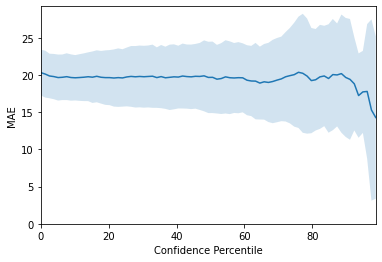

In [7]:
results, fig = evaluate_model(X, y, n_epochs=300, n_trials=10, kld_beta=50.0)
fig.show()

For graph features input, the results for the Bayesian GNN are below for the various datasets:

| |Photoswitch | Freesolv | ESOL | Lipophilicity |
|---|---|---|---|---|
| R2 | 0.8048 +- 0.0155 | 0.7884 +- 0.0056 | 0.8224 +- 0.0044 | 0.6208 +- 0.0199 |
| RMSE | 28.5302 +- 1.2050 | 0.9610 +- 0.0148  | 0.8800 +- 0.0098 |  0.7317 +- 0.0175 |
| MAE | 20.7182 +- 0.9928 | 0.7264 +- 0.0161 | 0.6622 +- 0.0079 | 0.5328 +- 0.0111 |
| NLPD | 0.9960 +- 0.1286 | 1.0060 +- 0.0153 | 1.6990 +- 0.1085 | 1.1406 +- 0.0120 |
